A Python implementation of [Sky Region Detection in a Single Image for Autonomous Ground Robot Navigation (Shen and Wang, 2013)](https://journals.sagepub.com/doi/full/10.5772/56884)

In [17]:
# ipython glue and helpers

import cv2
import numpy as np
from scipy import spatial
import os
import mmcv

def make_mask(b, image):
    mask = np.zeros((image.shape[0], image.shape[1], 1), dtype=np.uint8)
    for xx, yy in enumerate(b):
        mask[yy:, xx] = 255

    return mask


def display_mask(b, image, color=[0, 0, 255]):
    result = image.copy()
    overlay = np.full(image.shape, color, image.dtype)

    display(
        cv2.addWeighted(
            cv2.bitwise_and(overlay, overlay, mask=make_mask(b, image)),
            1,
            image,
            1,
            0,
            result
        )
    )


def display_cv2_image(image):
    return cv2.imencode('.png', image)[1].tostring()


ip = get_ipython()
png_f = ip.display_formatter.formatters['image/png']
png_f.for_type_by_name('numpy', 'ndarray', display_cv2_image);

In [18]:
def color_to_gradient(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.hypot(
        cv2.Sobel(gray, cv2.CV_64F, 1, 0),
        cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    )

In [19]:
def energy(b_tmp, image):
    sky_mask = make_mask(b_tmp, image)

    ground = np.ma.array(
        image,
        mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)
    ).compressed()
    sky = np.ma.array(
        image,
        mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)
    ).compressed()
    ground.shape = (ground.size//3, 3)
    sky.shape = (sky.size//3, 3)

    sigma_g, mu_g = cv2.calcCovarMatrix(
        ground,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    sigma_s, mu_s = cv2.calcCovarMatrix(
        sky,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )

    y = 2

    return 1 / (
        (y * np.linalg.det(sigma_s) + np.linalg.det(sigma_g)) +
        (y * np.linalg.det(np.linalg.eig(sigma_s)[1]) +
            np.linalg.det(np.linalg.eig(sigma_g)[1]))
    )


In [20]:
def calculate_border(grad, t):
    sky = np.full(grad.shape[1], grad.shape[0])

    for x in range(grad.shape[1]):
        border_pos = np.argmax(grad[:, x] > t)

        # argmax hax return 0 if nothing is > t
        if border_pos > 0:
            sky[x] = border_pos

    return sky

In [21]:
def calculate_border_optimal(image, thresh_min=5, thresh_max=600, search_step=5):
    grad = color_to_gradient(image)

    n = ((thresh_max - thresh_min) // search_step) + 1

    b_opt = None
    jn_max = 0

    for k in range(1, n + 1):
        t = thresh_min + ((thresh_max - thresh_min) // n - 1) * (k - 1)

        b_tmp = calculate_border(grad, t)
        jn = energy(b_tmp, image)

        if jn > jn_max:
            jn_max = jn
            b_opt = b_tmp

    return b_opt

In [22]:
def no_sky_region(bopt, thresh1, thresh2, thresh3):
    border_ave = np.average(bopt)
    asadsbp = np.average(np.absolute(np.diff(bopt)))

    return border_ave < thresh1 or (border_ave < thresh2 and asadsbp > thresh3)


In [23]:
def partial_sky_region(bopt, thresh4):
    return np.any(np.diff(bopt) > thresh4)

In [24]:
def refine_sky(bopt, image):
    sky_mask = make_mask(bopt, image)

    ground = np.ma.array(
        image,
        mask=cv2.cvtColor(cv2.bitwise_not(sky_mask), cv2.COLOR_GRAY2BGR)
    ).compressed()
    sky = np.ma.array(
        image,
        mask=cv2.cvtColor(sky_mask, cv2.COLOR_GRAY2BGR)
    ).compressed()
    ground.shape = (ground.size//3, 3)
    sky.shape = (sky.size//3, 3)

    ret, label, center = cv2.kmeans(
        np.float32(sky),
        2,
        None,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    sigma_s1, mu_s1 = cv2.calcCovarMatrix(
        sky[label.ravel() == 0],
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    ic_s1 = cv2.invert(sigma_s1, cv2.DECOMP_SVD)[1]

    sigma_s2, mu_s2 = cv2.calcCovarMatrix(
        sky[label.ravel() == 1],
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    ic_s2 = cv2.invert(sigma_s2, cv2.DECOMP_SVD)[1]

    sigma_g, mu_g = cv2.calcCovarMatrix(
        ground,
        None,
        cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE
    )
    icg = cv2.invert(sigma_g, cv2.DECOMP_SVD)[1]

    if cv2.Mahalanobis(mu_s1, mu_g, ic_s1) > cv2.Mahalanobis(mu_s2, mu_g, ic_s2):
        mu_s = mu_s1
        sigma_s = sigma_s1
        ics = ic_s1
    else:
        mu_s = mu_s2
        sigma_s = sigma_s2
        ics = ic_s2

    for x in range(image.shape[1]):
        cnt = np.sum(np.less(
            spatial.distance.cdist(
                image[0:bopt[x], x],
                mu_s,
                'mahalanobis',
                VI=ics
            ),
            spatial.distance.cdist(
                image[0:bopt[x], x],
                mu_g,
                'mahalanobis',
                VI=icg
            )
        ))

        if cnt < (bopt[x] / 2):
            bopt[x] = 0

    return bopt


In [25]:
def detect_sky(image):
    display(image)

    bopt = calculate_border_optimal(image)

    if no_sky_region(bopt, image.shape[0]/30, image.shape[0]/4, 5):
        display("No sky detected")
        return

    display_mask(bopt, image)

    if partial_sky_region(bopt, image.shape[1]/3):
        bnew = refine_sky(bopt, image)

        display_mask(bnew, image)

In [ ]:
# input_image = cv2.imread("fixtures/full_sky.png")
input_image = cv2.imread("fixtures/partial_sky.png")
# input_image = cv2.imread("fixtures/no_sky.png")

detect_sky(input_image)

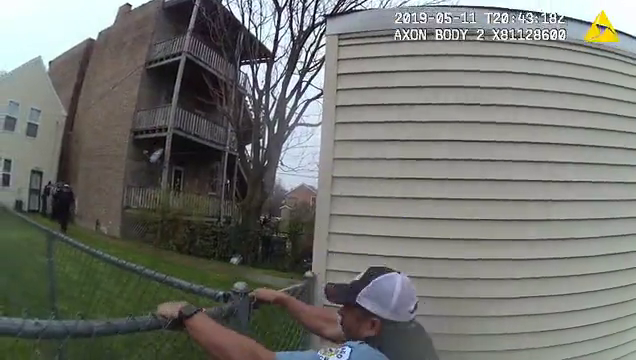

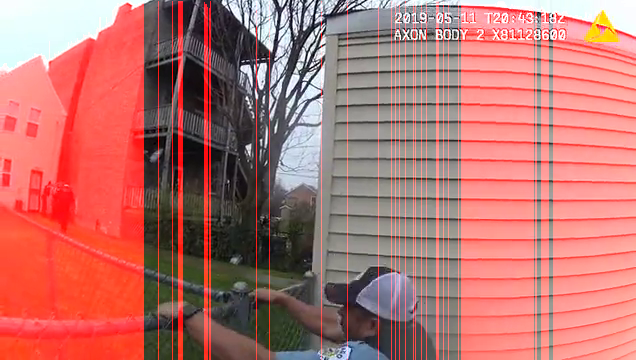

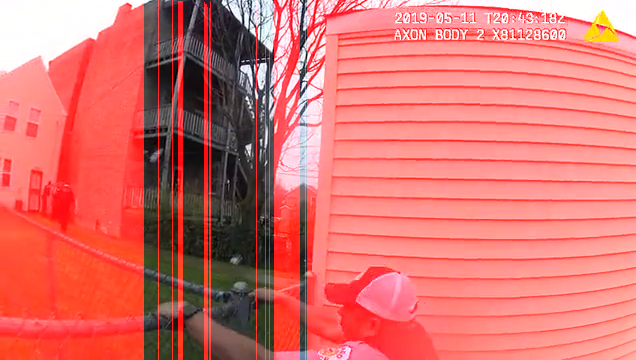

In [29]:
vid_num = 300
frame_num = 400
root_dir = '/n/fs/vai-bwc-scr/'
vid_dir = os.path.join(root_dir, 'videos')
vid_names = os.listdir(vid_dir)
vid_name = vid_names[vid_num]
video = mmcv.VideoReader(os.path.join(vid_dir, vid_name))
frame = video[frame_num]
detect_sky(frame)